# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import os
import sys
import cv2
import random
import datetime
import neptune
import tempfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as prep_input_mobilenetv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


if '../../../notebooks/' not in sys.path:
    sys.path.append('../../../notebooks/')

import utils.constants as cts
import utils.draw_utils as dr

from models.oface_mouth_model import OpenfaceMouth

from data_loaders.data_loader import DLName

from net_data_loaders.net_data_loader import NetDataLoader

from gt_loaders.gen_gt import Eval
from gt_loaders.fvc_gt import FVC_GTLoader
from gt_loaders.pybossa_gt import PybossaGTLoader

# Load the TensorBoard notebook extension
# %load_ext tensorboard

## Restrict GPU Memory Growth

In [3]:
## restrict memory growth -------------------

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
    raise Exception("Invalid device or cannot modify virtual devices once initialized.")

## restrict memory growth -------------------

# Start Experiment Manager

In [14]:
def lr_scheduler(epoch):
#     if epoch < 10:
#         new_lr = PARAMS['learning_rate']
#     else:
    new_lr = PARAMS['learning_rate'] * np.exp(0.1 * ((epoch//50)*50 - epoch))

    #neptune.log_metric('learning_rate', new_lr)
    return new_lr

# Load Data

In [62]:
m = OpenfaceMouth()
req = cts.ICAO_REQ.MOUTH
dl_names = [DLName.FVC_PYBOSSA]
print(f'DL names: {dl_names}')

print('Loading data')
netDataLoader = NetDataLoader(m, req, dl_names, True)
in_data = netDataLoader.load_data()
# in_data = pd.read_csv(cts.LABELS_FQA_SCORES_DATA_PATH)
# in_data = in_data[in_data.fqa_score >= 0.5]
# in_data = in_data.astype({'comp':'str'})
print('Data loaded')

DL names: [<DLName.FVC_PYBOSSA: 'fvc_pybossa'>]
Loading data
Input data.shape: (5780, 4)
Data loaded


In [63]:
in_data.head()

,origin,img_name,comp,aligned
0,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,1,True
1,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0,True
2,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0,True
3,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0,True
4,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,1,True


In [65]:
print(in_data[in_data.comp == Eval.COMPLIANT.value].shape[0], in_data[in_data.comp == Eval.NON_COMPLIANT.value].shape[0])

4568 1212


In [66]:
final_df = pd.DataFrame()

# df_comp = in_data[in_data.comp == '1.0']
# df_non_comp = in_data[in_data.comp == '0.0']
df_comp = in_data[in_data.comp == Eval.COMPLIANT.value]
df_non_comp = in_data[in_data.comp == Eval.NON_COMPLIANT.value]

print(df_comp.shape, df_non_comp.shape)

n_imgs = df_non_comp.shape[0]
print(n_imgs)

df_comp = df_comp[:n_imgs].copy()

final_df = final_df.append(df_comp)
final_df = final_df.append(df_non_comp)

print(final_df.shape)
# print(final_df[final_df.comp == '1.0'].shape[0])
# print(final_df[final_df.comp == '0.0'].shape[0])
print(final_df[final_df.comp == Eval.COMPLIANT.value].shape[0])
print(final_df[final_df.comp == Eval.NON_COMPLIANT.value].shape[0])

(4568, 4) (1212, 4)
1212
(2424, 4)
1212
1212


# Data Generators

In [72]:
TRAIN_PROP = 0.8
VALID_PROP = 0.1
TEST_PROP = 0.1
SEED = 42

print(f'N: {len(in_data)}')

INIT_LR = 1e-4
EPOCHS = 30
BS = 64
SHUFFLE = True
DROPOUT = 0.5
# EARLY_STOPPING = 10
OPTIMIZER = 'Adam'
DENSE_UNITS = 128

print('Starting data generators')
train_valid_df = final_df.sample(frac=TRAIN_PROP+VALID_PROP, random_state=SEED)
test_df = final_df[~final_df.img_name.isin(train_valid_df.img_name)]
# train_valid_df = in_data.sample(frac=TRAIN_PROP+VALID_PROP, random_state=SEED)
# test_df = in_data[~in_data.img_name.isin(train_valid_df.img_name)]

print('Starting data generators')
datagen = ImageDataGenerator(preprocessing_function=prep_input_mobilenetv2, 
                             validation_split=0.2)


train_gen = datagen.flow_from_dataframe(train_valid_df, 
                                        x_col="img_name", 
                                        y_col="comp",
                                        target_size=(224, 224),
                                        class_mode="raw",
                                        batch_size=BS, 
                                        subset='training',
                                        shuffle=False,
                                        seed=SEED)

validation_gen = datagen.flow_from_dataframe(train_valid_df,
                                            x_col="img_name", 
                                            y_col="comp",
                                            target_size=(224, 224),
                                            class_mode="raw",
                                            batch_size=BS, 
                                            subset='validation',
                                            shuffle=False,
                                            seed=SEED)

test_gen = datagen.flow_from_dataframe(test_df,
                                       x_col="img_name", 
                                       y_col="comp",
                                       target_size=(224, 224),
                                       class_mode="raw",
                                       batch_size=BS,
                                       shuffle=False)

print(f'TOTAL: {train_gen.n + validation_gen.n + test_gen.n}')

N: 5780
Starting data generators
Starting data generators
Found 1746 validated image filenames.
Found 436 validated image filenames.
Found 242 validated image filenames.
TOTAL: 2424


# Create Experiment

In [73]:
# Define parameters
PARAMS = {'batch_size': BS,
          'n_epochs': EPOCHS,
          'shuffle': SHUFFLE,
          'dense_units': DENSE_UNITS,
          'learning_rate': INIT_LR,
          'optimizer': OPTIMIZER,
          'dropout': DROPOUT,
#           'early_stopping': EARLY_STOPPING,
          'train_prop': TRAIN_PROP,
          'validation_prop': VALID_PROP,
          'test_prop': TEST_PROP,
          'n_train': train_gen.n,
          'n_validation': validation_gen.n,
          'n_test': test_gen.n,
          'seed': SEED}

In [10]:
print('Creating experiment')
neptune.create_experiment(name='train_mobilenetv2',
                          params=PARAMS,
                          properties={
                                      'dl_names': str([dl_name.value for dl_name in dl_names]),
                                      'dl_aligned': True,
                                      'icao_req': req.value,
                                      'tagger_model': m.get_model_name().value},
                          description='Changing learning rate scheduler function to improve results from experiment IC-19',
                          tags=['mobilenetv2'],
                          upload_source_files=['train_mobilenetv2.py']
                         )

Creating experiment
https://ui.neptune.ai/guilhermemg/icao-nets-training/e/IC-20


Experiment(IC-20)

# Training Model

In [74]:
class MyCallback(tf.keras.callbacks.Callback): 
    def __init__(self, val_gen):
        self.val_gen = val_gen
        self.out_file_path = 'output/out.csv'
    
    def __clean_out_file(self):
        if os.path.exists(self.out_file_path):
            os.remove(self.out_file_path)
    
    def on_epoch_end(self, epoch, logs={}): 
        if epoch == 0:
            self.__clean_out_file()

#         print(f'Validation Accuracy: {self.model.evaluate(self.val_gen, batch_size=BS)}')
        
        with open(self.out_file_path,'a') as f:
            predIxs = self.model.predict(self.val_gen, batch_size=BS)
            Y = self.val_gen.labels
            Y_hat = np.argmax(predIxs, axis=1)
            for idx,(y,y_h) in enumerate(zip(Y,Y_hat)):
                if epoch == 0 and idx == 0:
                    f.writelines('epoch,idx,y,y_hat\n')
                f.writelines(f'{epoch+1},{idx},{y},{y_h}\n')    

In [84]:
print('Training network')

# log_dir = "tensorboard_out/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint_filepath = '/output/checkpoint_epoch_{}'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_freq='epoch')

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3),
	input_tensor=Input(shape=(224,224,3)))

for layer in baseModel.layers:
	layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(PARAMS['dense_units'], activation="relu")(headModel)
headModel = Dropout(PARAMS['dropout'])(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Log model summary
# model.summary(print_fn=lambda x: neptune.log_text('model_summary', x))

# train the head of the network
H = model.fit(
        train_gen,
        steps_per_epoch=train_gen.n // BS,
        validation_data=validation_gen,
        validation_steps=validation_gen.n // BS,
        epochs=EPOCHS,
        callbacks=[
#             LambdaCallback(on_epoch_end = lambda epoch, logs: log_data(logs)),
#             EarlyStopping(patience=PARAMS['early_stopping'], monitor='accuracy', restore_best_weights=True),
            LearningRateScheduler(lr_scheduler),
#             MyCallback(validation_gen)
#               tensorboard_callback
        ])

Training network
Epoch 1/30
27/27 [==============================] - 4s 156ms/step - loss: 0.8571 - accuracy: 0.4715 - val_loss: 0.7127 - val_accuracy: 0.5052
Epoch 2/30
27/27 [==============================] - 4s 143ms/step - loss: 0.7646 - accuracy: 0.4893 - val_loss: 0.7054 - val_accuracy: 0.5339
Epoch 3/30
27/27 [==============================] - 4s 133ms/step - loss: 0.7314 - accuracy: 0.5012 - val_loss: 0.7011 - val_accuracy: 0.4974
Epoch 4/30
27/27 [==============================] - 4s 140ms/step - loss: 0.7157 - accuracy: 0.4869 - val_loss: 0.6987 - val_accuracy: 0.5078
Epoch 5/30
27/27 [==============================] - 4s 143ms/step - loss: 0.7095 - accuracy: 0.4637 - val_loss: 0.6973 - val_accuracy: 0.5026
Epoch 6/30
27/27 [==============================] - 4s 140ms/step - loss: 0.7037 - accuracy: 0.4875 - val_loss: 0.6964 - val_accuracy: 0.4974
Epoch 7/30
27/27 [==============================] - 4s 142ms/step - loss: 0.7020 - accuracy: 0.4881 - val_loss: 0.6959 - val_accura

# Plots

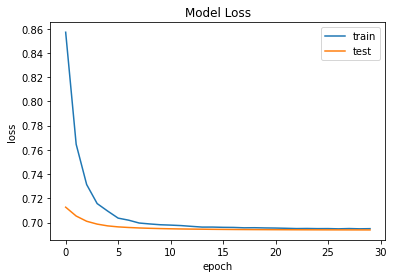

In [87]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

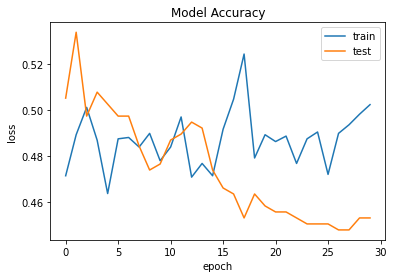

In [88]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Saving Trained Model

# Test Trained Model

In [29]:
print("Testing Trained Model")

predIdxs = model.predict(test_gen, batch_size=BS)
y_hat = np.argmax(predIdxs, axis=1)

print(classification_report(test_gen.labels, y_hat, target_names=['NON_COMP','COMP']))

print(f'Model Accuracy: {round(accuracy_score(test_gen.labels, y_hat), 4)}')

Testing Trained Model
              precision    recall  f1-score   support

    NON_COMP       0.65      0.64      0.64       137
        COMP       0.54      0.55      0.54       105

    accuracy                           0.60       242
   macro avg       0.59      0.59      0.59       242
weighted avg       0.60      0.60      0.60       242

Model Accuracy: 0.5992


# Evaluate Model

In [31]:
print('Evaluating model')
eval_metrics = model.evaluate(test_gen, batch_size=BS, verbose=0)

print(f'Loss: {round(eval_metrics[0], 4)}')
print(f'Accuracy: {round(eval_metrics[1], 4)}')

Evaluating model
Loss: 0.6937
Accuracy: 0.5992


# Finishing Experiment Manager